In [1]:
# Step 0: Setup

!pip -q install pandas numpy matplotlib seaborn scipy

import warnings
warnings.filterwarnings("ignore")

import os, io, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import files

plt.rcParams["figure.figsize"] = (8,5)
plt.rcParams["axes.grid"] = True

# Create output folders
os.makedirs("plots", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [6]:
# =========================
# Step 1: Upload & Load CSV (with encoding fix)
# =========================
from google.colab import files
import io
import pandas as pd

print("Upload your dataset CSV (e.g., Global_Superstore2.csv)")
uploaded = files.upload()

fname = next(iter(uploaded))

# Try utf-8, fallback to latin1 (works for Global Superstore datasets)
try:
    df_raw = pd.read_csv(io.BytesIO(uploaded[fname]), encoding="utf-8")
except UnicodeDecodeError:
    df_raw = pd.read_csv(io.BytesIO(uploaded[fname]), encoding="latin1")

# Try parsing date columns automatically
def try_parse_dates(df):
    for c in df.columns:
        if "date" in c.lower():
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

df = try_parse_dates(df_raw.copy())
print("Shape:", df.shape)
display(df.head())


Upload your dataset CSV (e.g., Global_Superstore2.csv)


Saving Global_Superstore2.csv to Global_Superstore2 (1).csv
Shape: (51290, 24)


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,2012-07-31,2012-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2013-77878,2013-02-05,2013-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical
2,25330,IN-2013-71249,2013-10-17,2013-10-18,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,...,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID",5175.171,9,0.1,919.9710,915.49,Medium
3,13524,ES-2013-1579342,2013-01-28,2013-01-30,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,...,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless",2892.510,5,0.1,-96.5400,910.16,Medium
4,47221,SG-2013-4320,2013-11-05,2013-11-06,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,...,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed",2832.960,8,0.0,311.5200,903.04,Critical


In [7]:
# =========================
# Step 2: Basic Info & Missingness
# =========================
print("dtypes:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())


dtypes:
 Row ID                     int64
Order ID                  object
Order Date        datetime64[ns]
Ship Date         datetime64[ns]
Ship Mode                 object
Customer ID               object
Customer Name             object
Segment                   object
City                      object
State                     object
Country                   object
Postal Code              float64
Market                    object
Region                    object
Product ID                object
Category                  object
Sub-Category              object
Product Name              object
Sales                    float64
Quantity                   int64
Discount                 float64
Profit                   float64
Shipping Cost            float64
Order Priority            object
dtype: object

Missing values per column:
 Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Nam

In [8]:
# =========================
# Step 3: Remove Duplicates
# =========================
before = len(df)
df = df.drop_duplicates()
dups_removed = before - len(df)
print("Duplicates removed:", dups_removed, "| New shape:", df.shape)


Duplicates removed: 0 | New shape: (51290, 24)


In [9]:
# =========================
# Step 4: Fill Missing Values
#   - numeric -> median
#   - categorical -> mode
# =========================
num_cols = df.select_dtypes(include="number").columns.tolist()
cat_cols = df.select_dtypes(exclude=["number","datetime"]).columns.tolist()

missing_before = df.isna().sum().sum()

for c in num_cols:
    df[c] = df[c].fillna(df[c].median())

for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

# keep datetime NaT as-is (often meaningful); drop rows if you prefer:
# for c in df.select_dtypes(include="datetime").columns:
#     df = df[~df[c].isna()]

missing_after = df.isna().sum().sum()
print(f"Missing filled: {missing_before - missing_after} | Remaining missing: {missing_after}")


Missing filled: 41296 | Remaining missing: 0


In [10]:
# =========================
# Step 5: Detect & Handle Outliers (IQR method)
#   Removes rows outside [Q1-1.5*IQR, Q3+1.5*IQR] for each numeric col
# =========================
def remove_outliers_iqr(dataframe, cols, factor=1.5):
    dfc = dataframe.copy()
    outlier_counts = {}
    for col in cols:
        if dfc[col].nunique() < 2:  # skip constant columns
            outlier_counts[col] = 0
            continue
        Q1, Q3 = dfc[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        lower, upper = Q1 - factor*IQR, Q3 + factor*IQR
        before = len(dfc)
        dfc = dfc[(dfc[col].between(lower, upper)) | (dfc[col].isna())]
        outlier_counts[col] = before - len(dfc)
    return dfc, outlier_counts

df_no_out, out_stats = remove_outliers_iqr(df, num_cols, factor=1.5)
print("Rows before:", len(df), "| after:", len(df_no_out), "| removed:", len(df) - len(df_no_out))
print("Outliers removed by column:", out_stats)

# Use the outlier-removed set going forward
df = df_no_out.reset_index(drop=True)


Rows before: 51290 | after: 25882 | removed: 25408
Outliers removed by column: {'Row ID': 0, 'Postal Code': 9994, 'Sales': 4548, 'Quantity': 1796, 'Discount': 1322, 'Profit': 5336, 'Shipping Cost': 2412}


In [11]:
# =========================
# Step 6: Statistical Analysis
# =========================
desc = df[num_cols].agg(["mean","median","std","var"]).T
display(desc)

corr = df[num_cols].corr(numeric_only=True)
display(corr.style.background_gradient(cmap="coolwarm"))


,mean,median,std,var
Row ID,22876.987057,20329.5000,15605.923473,2.435448e+08
Postal Code,56430.500000,56430.5000,0.000000,0.000000e+00
Sales,74.783825,50.3766,73.131964,5.348284e+03
Quantity,2.735337,2.0000,1.588873,2.524518e+00
Discount,0.112225,0.0000,0.186080,3.462586e-02
Profit,10.113063,6.8400,18.980380,3.602548e+02
Shipping Cost,6.746957,4.5900,6.182084,3.821816e+01


,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
Row ID,1.000000,nan,-0.062639,-0.321297,-0.040053,-0.001348,-0.054994
Postal Code,nan,nan,nan,nan,nan,nan,nan
Sales,-0.062639,nan,1.000000,0.263221,-0.165440,0.433118,0.721405
Quantity,-0.321297,nan,0.263221,1.000000,0.012188,0.117535,0.242387
Discount,-0.040053,nan,-0.165440,0.012188,1.000000,-0.557992,-0.166184
Profit,-0.001348,nan,0.433118,0.117535,-0.557992,1.000000,0.385317
Shipping Cost,-0.054994,nan,0.721405,0.242387,-0.166184,0.385317,1.000000


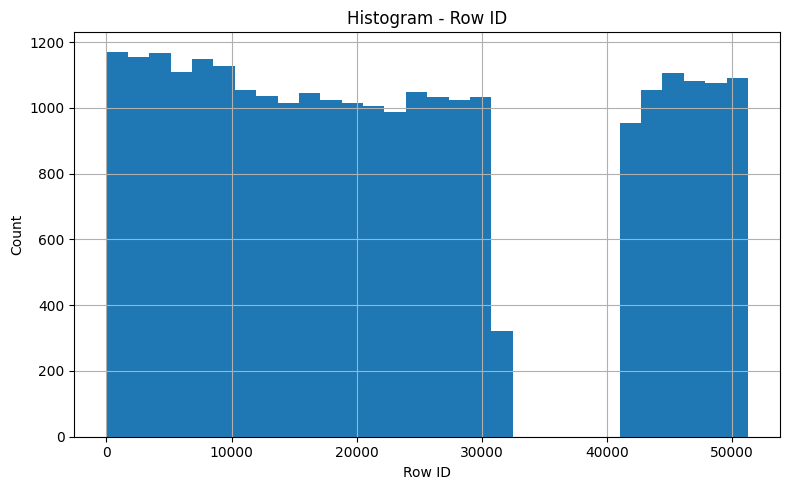

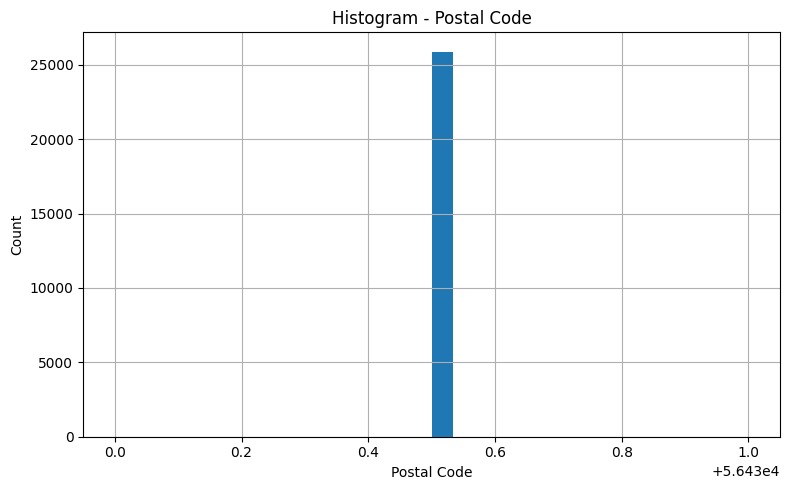

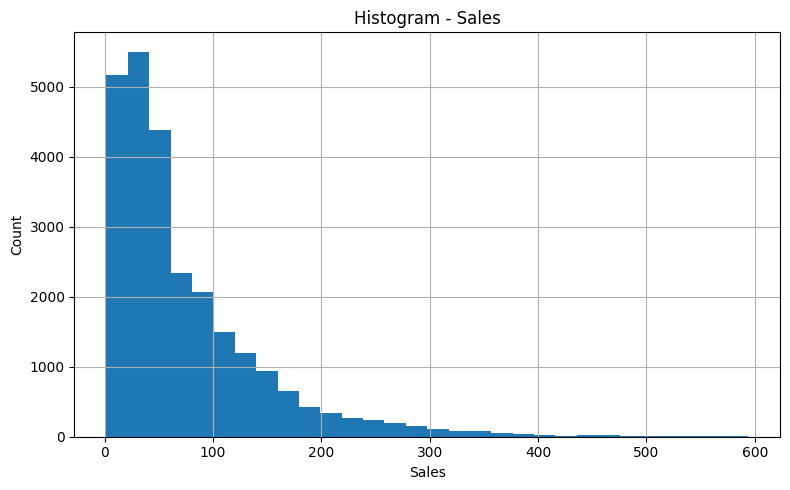

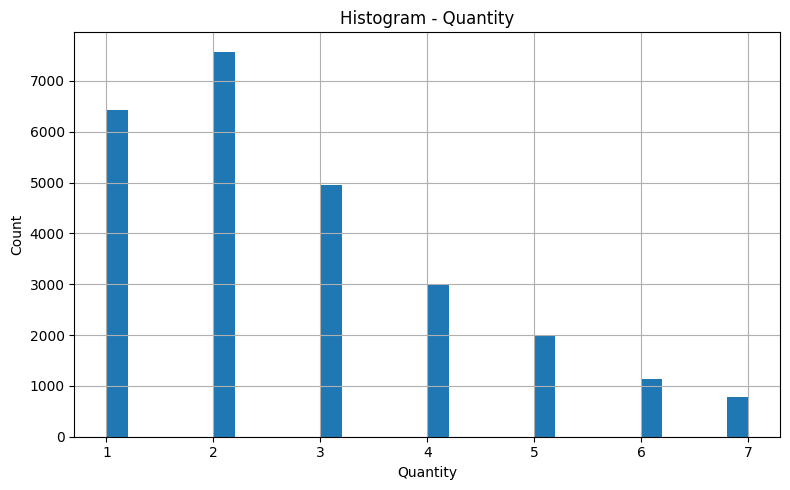

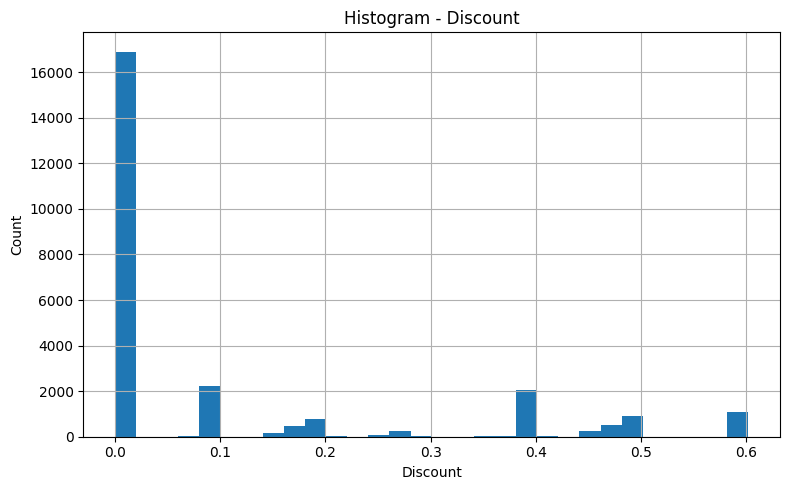

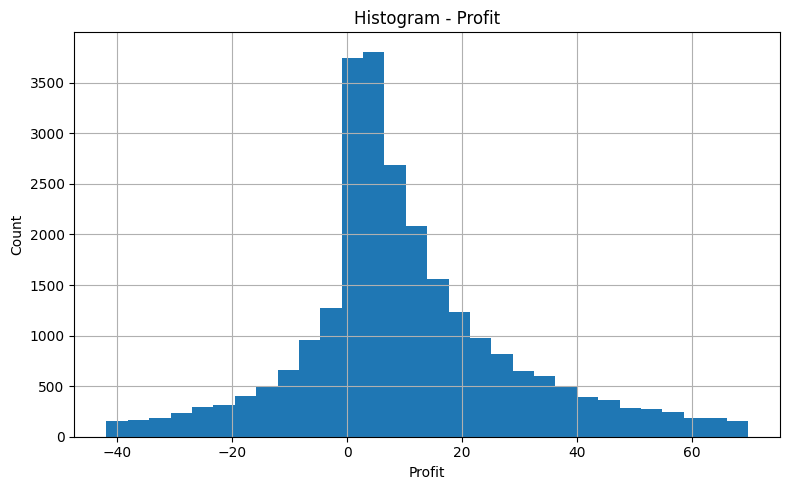

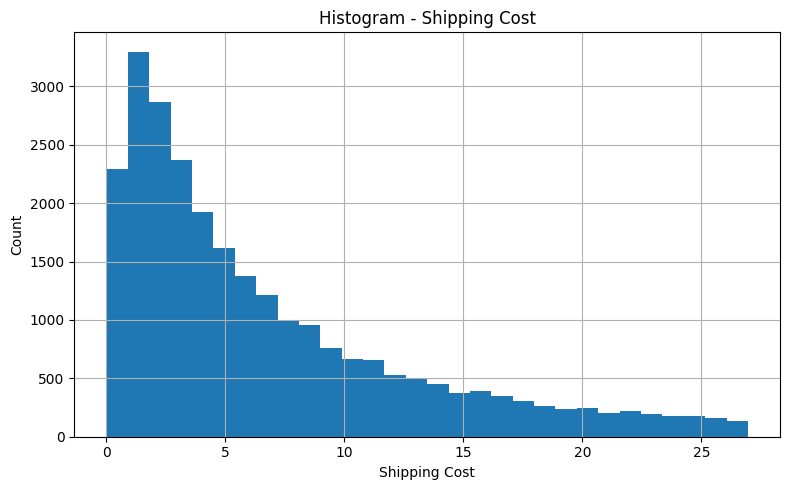

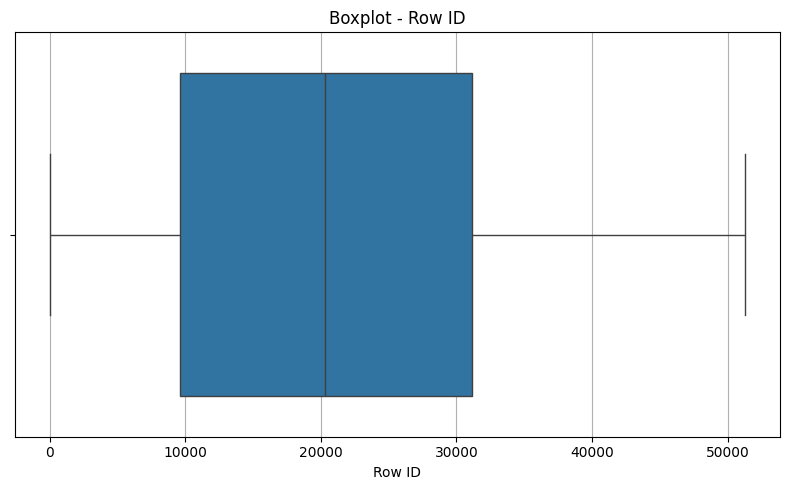

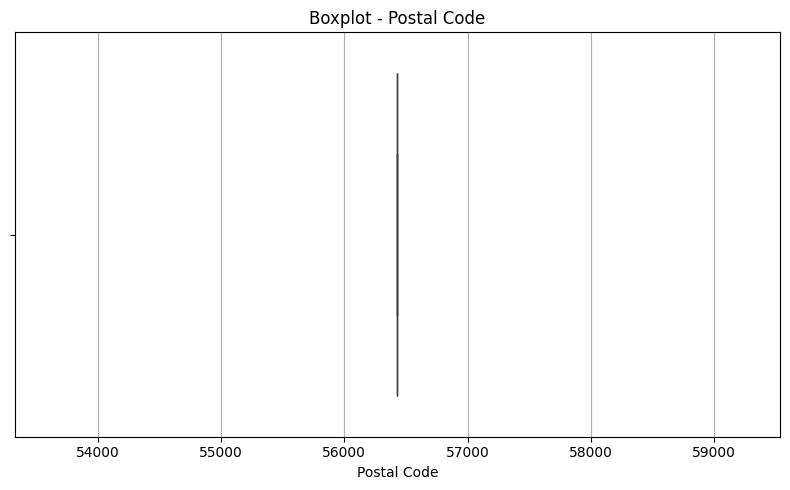

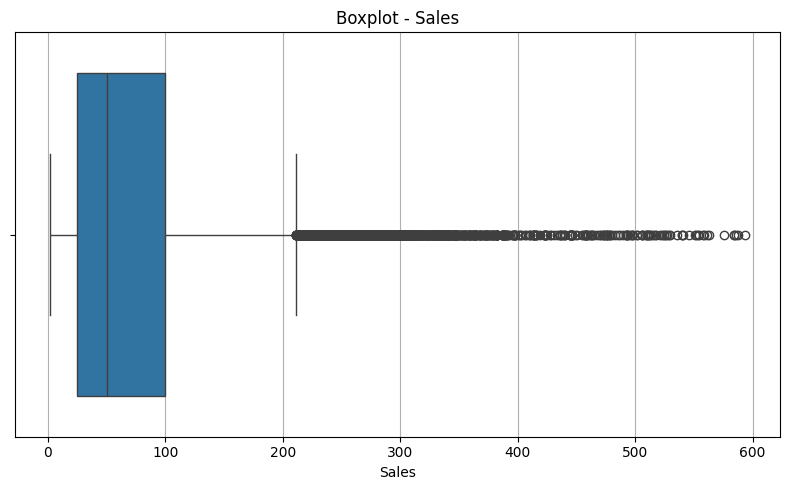

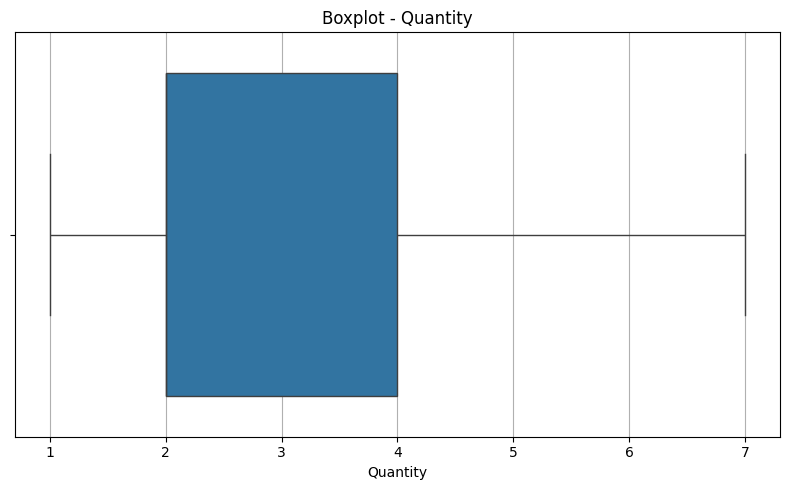

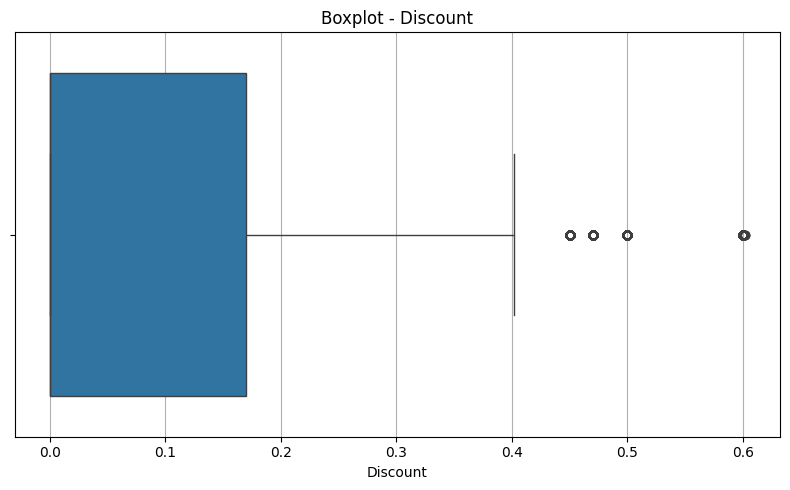

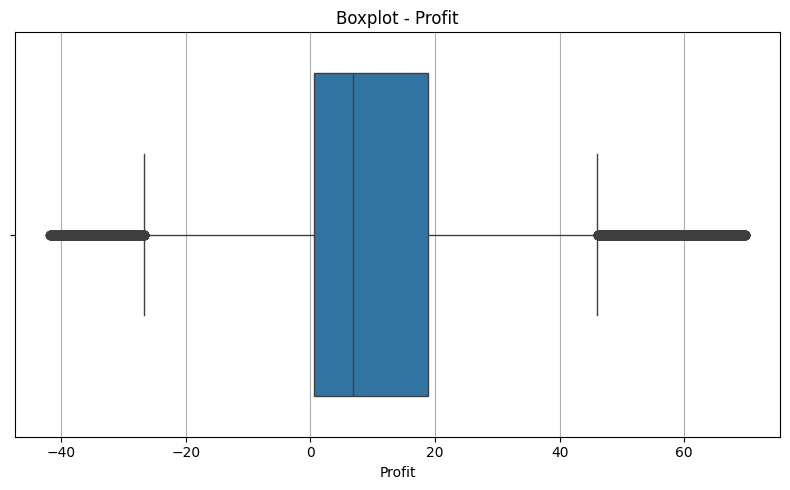

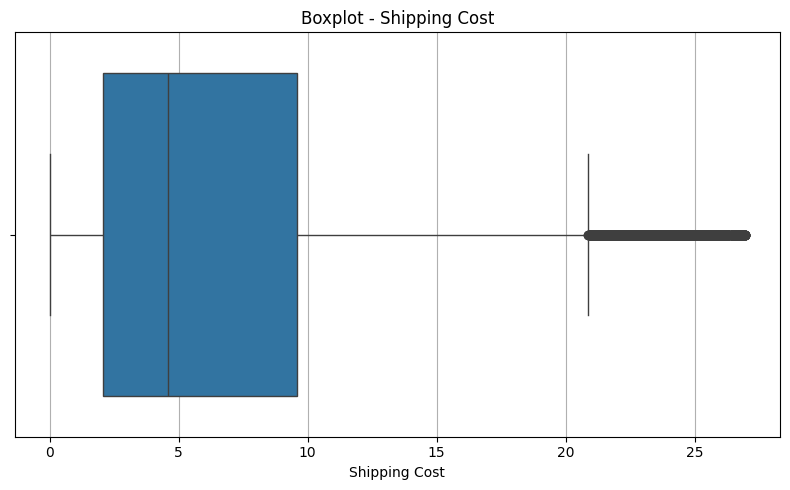

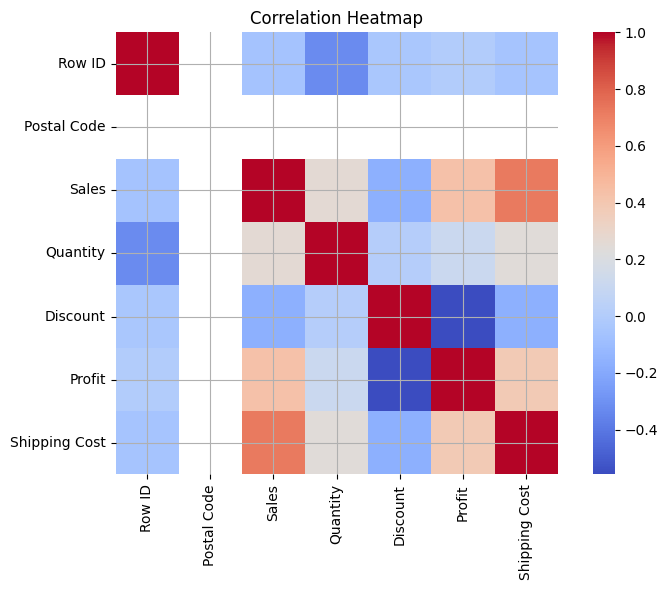

In [12]:
# =========================
# Step 7: Visualizations
#   - Histograms for numeric features
#   - Boxplots for numeric features
#   - Correlation Heatmap
# =========================

# Histograms
for c in num_cols:
    plt.figure()
    df[c].hist(bins=30)
    plt.title(f"Histogram - {c}")
    plt.xlabel(c); plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"plots/hist_{c}.png", dpi=150)
    plt.show()

# Boxplots
for c in num_cols:
    plt.figure()
    sns.boxplot(x=df[c], orient="h")
    plt.title(f"Boxplot - {c}")
    plt.tight_layout()
    plt.savefig(f"plots/box_{c}.png", dpi=150)
    plt.show()

# Heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=False, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.savefig("plots/correlation_heatmap.png", dpi=150)
plt.show()


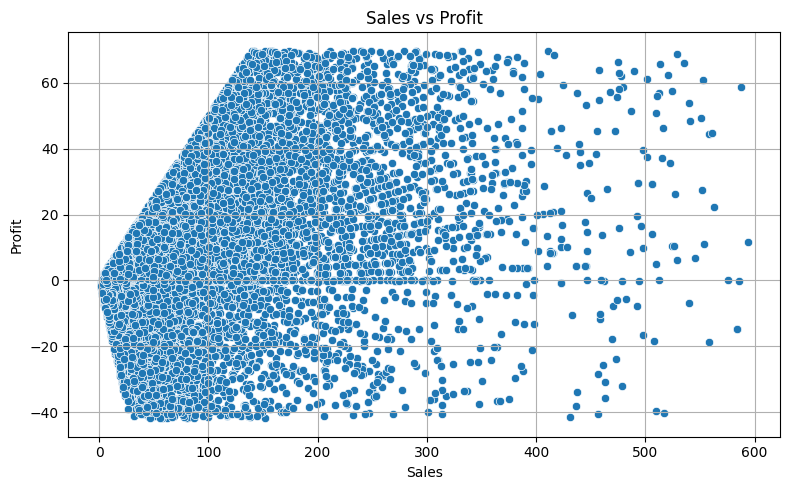

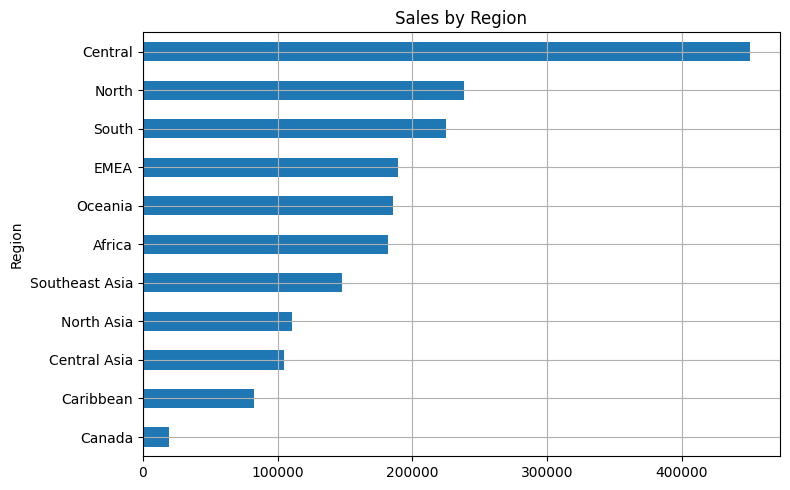

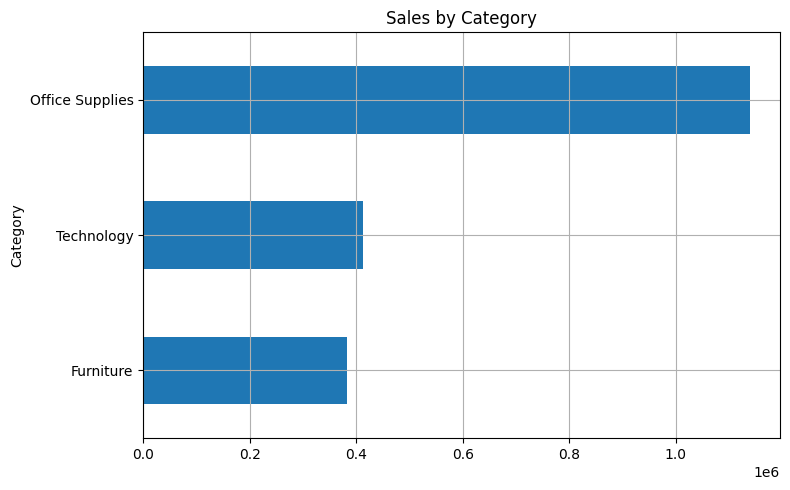

In [13]:
# =========================
# Step 8: Optional domain visuals if columns exist (Sales/Profit/Region/Category)
# =========================
if set(["Sales","Profit"]).issubset(df.columns):
    plt.figure()
    sns.scatterplot(data=df, x="Sales", y="Profit")
    plt.title("Sales vs Profit")
    plt.tight_layout()
    plt.savefig("plots/sales_vs_profit.png", dpi=150)
    plt.show()

if "Region" in df.columns and "Sales" in df.columns:
    plt.figure()
    df.groupby("Region")["Sales"].sum().sort_values().plot(kind="barh")
    plt.title("Sales by Region")
    plt.tight_layout()
    plt.savefig("plots/sales_by_region.png", dpi=150)
    plt.show()

if "Category" in df.columns and "Sales" in df.columns:
    plt.figure()
    df.groupby("Category")["Sales"].sum().sort_values().plot(kind="barh")
    plt.title("Sales by Category")
    plt.tight_layout()
    plt.savefig("plots/sales_by_category.png", dpi=150)
    plt.show()


In [14]:
# =========================
# Step 9: Save Cleaned Data & Auto Summary Report
# =========================
df.to_csv("outputs/cleaned_dataset.csv", index=False)

# Top correlations (absolute) excluding self-corr
top_corr = (
    corr.where(~np.eye(corr.shape[0], dtype=bool))
        .abs()
        .stack()
        .sort_values(ascending=False)
        .head(10)
)

report = []
report.append(f"# EDA Summary\n")
report.append(f"- Original shape: {df_raw.shape}")
report.append(f"- After duplicate removal: {df_raw.drop_duplicates().shape}")
report.append(f"- Final shape after outliers: {df.shape}")
report.append(f"- Duplicates removed: {dups_removed}")
report.append(f"- Remaining missing cells: {df.isna().sum().sum()}")
report.append(f"\n## Numeric Columns\n- {', '.join(num_cols) if num_cols else 'None'}")
report.append("\n## Descriptive Stats (mean/median/std/var)\n")
report.append(desc.to_markdown())
report.append("\n## Top 10 Absolute Correlations (pairwise)\n")
report.append(top_corr.to_frame("abs_corr").to_markdown())

# Optional domain-specific snippets
if {"Sales","Profit"}.issubset(df.columns):
    sales_sum = df["Sales"].sum()
    profit_sum = df["Profit"].sum()
    report.append(f"\n- Total Sales: {sales_sum:,.2f}")
    report.append(f"- Total Profit: {profit_sum:,.2f}")

if "Region" in df.columns and "Sales" in df.columns:
    top_region = df.groupby("Region")["Sales"].sum().sort_values(ascending=False).head(3)
    report.append("\n### Top Regions by Sales\n")
    report.append(top_region.to_markdown())

if "Category" in df.columns and "Sales" in df.columns:
    top_cat = df.groupby("Category")["Sales"].sum().sort_values(ascending=False).head(5)
    report.append("\n### Top Categories by Sales\n")
    report.append(top_cat.to_markdown())

with open("outputs/EDA_summary.md","w") as f:
    f.write("\n".join(report))

print("Saved:")
print("- outputs/cleaned_dataset.csv")
print("- outputs/EDA_summary.md")
print("- plots/*.png")


Saved:
- outputs/cleaned_dataset.csv
- outputs/EDA_summary.md
- plots/*.png


Coefficients (Profit, Discount): [ 1.91349026 43.94347466]
Intercept: 50.62713398382501
MSE: 4126.4883 | R²: 0.2006


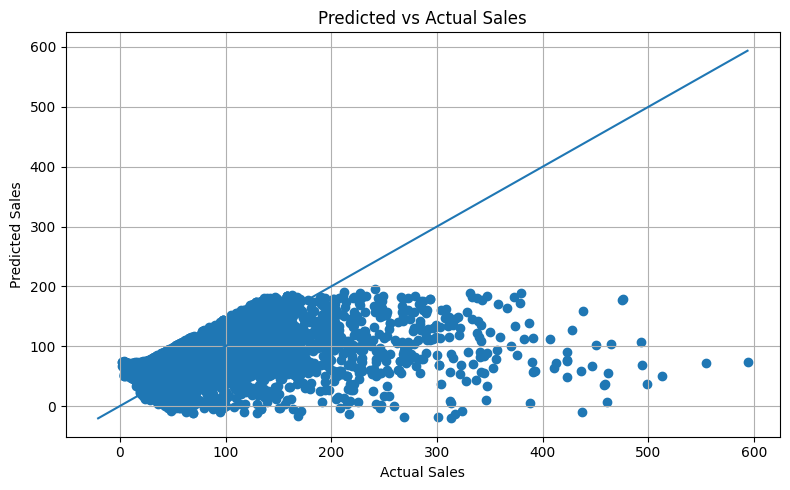

In [17]:
# =========================
# Step 6: Predictive Modeling — Linear Regression for Sales
#   Features: Profit, Discount
# =========================
features = ["Profit","Discount"]
target = "Sales"

# Guard for missing columns
for c in features + [target]:
    assert c in df.columns, f"Missing required column: {c}"

X = df[features].copy()
y = df[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print("Coefficients (Profit, Discount):", model.coef_)
print("Intercept:", model.intercept_)
print(f"MSE: {mse:.4f} | R²: {r2:.4f}")

# Save model
joblib.dump(model, "sales_outputs/linear_regression_sales.pkl")

# Predicted vs Actual plot
plt.figure()
plt.scatter(y_test, y_pred)
plt.title("Predicted vs Actual Sales")
plt.xlabel("Actual Sales"); plt.ylabel("Predicted Sales")
# Reference line
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims)
plt.tight_layout()
plt.savefig("sales_plots/predicted_vs_actual.png", dpi=150)
plt.show()


In [19]:
# =========================
# Step 7: Insights & Simple Recommendations (Auto)
# =========================
lines = []
lines.append("# Sales Insights & Recommendations\n")

# --- Compute aggregates ---
sales_by_region = df.groupby("Region")["Sales"].sum()
sales_by_cat = df.groupby("Category")["Sales"].sum()

# --- Top regions & categories ---
top_regions = sales_by_region.sort_values(ascending=False).head(5)
top_cats    = sales_by_cat.sort_values(ascending=False).head(5)

lines.append("## Top Regions by Sales\n")
lines.append(top_regions.to_frame("Sales").to_markdown())
lines.append("\n## Top Categories by Sales\n")
lines.append(top_cats.to_frame("Sales").to_markdown())

# --- Correlations ---
corr_discount_sales = df["Discount"].corr(df["Sales"])
corr_profit_sales   = df["Profit"].corr(df["Sales"])
lines.append(f"\n- Corr(Discount, Sales): {corr_discount_sales:.3f}")
lines.append(f"- Corr(Profit, Sales): {corr_profit_sales:.3f}")

# --- Discount buckets (avg sales per discount range) ---
bins = pd.interval_range(start=df["Discount"].min(), end=df["Discount"].max(), periods=5)
disc_bucket = pd.cut(df["Discount"], bins=bins, include_lowest=True)
avg_sales_by_disc = df.groupby(disc_bucket)["Sales"].mean().sort_index()
lines.append("\n## Avg Sales by Discount Bucket\n")
lines.append(avg_sales_by_disc.to_frame("AvgSales").to_markdown())

# --- Model Performance (from Step 6) ---
lines.append("\n## Model Performance\n")
lines.append(f"- MSE: {mse:.4f}")
lines.append(f"- R²: {r2:.4f}")
lines.append(f"- Coefficients [Profit, Discount]: {model.coef_}")
lines.append(f"- Intercept: {model.intercept_}")

# --- Save insights report ---
with open("sales_outputs/sales_insights.md","w") as f:
    f.write("\n".join(lines))

print("Saved:")
print("- sales_outputs/sales_insights.md")


Saved:
- sales_outputs/sales_insights.md
